In [1]:
import numpy as np
import math

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [3]:
from graphviz import Digraph

In [4]:
#save and load function
import pickle
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
#load the data
df_msft = load_obj("pkl_data/result_test_30yr_df_final")

In [6]:
df_msft

,date,close_price,open_price,high_price,low_price,adj_volume,adjdilutedeps,dividend
0,1990-01-02,88.75,87.25,88.75,86.120,53033616.0,NaN,NaN
1,1990-01-03,89.25,89.50,90.25,88.500,113772816.0,NaN,NaN
2,1990-01-04,91.87,89.25,92.00,88.750,125740800.0,NaN,NaN
3,1990-01-05,89.62,91.50,92.00,89.500,69564816.0,NaN,NaN
4,1990-01-08,91.00,89.50,91.00,88.500,58982400.0,NaN,NaN
...,...,...,...,...,...,...,...,...
7553,2019-12-06,151.75,150.99,151.87,150.270,16410400.0,5.06,0.51
7554,2019-12-09,151.36,151.07,152.21,150.910,16741350.0,5.06,0.51
7555,2019-12-10,151.13,151.29,151.89,150.765,16481060.0,5.06,0.51
7556,2019-12-11,151.70,151.54,151.87,150.330,18860001.0,5.06,0.51


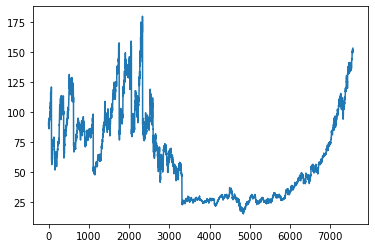

In [7]:
#data vitualization
import matplotlib.pyplot as plt

n = len(df_msft)
x = np.linspace(0, n, n)
y = df_msft['close_price']
plt.plot(x, y)
plt.show()


In [8]:
#Garman Klass Vol Estimator

def garman_klass(N,n,high_p,low_p,close_p,open_p):
    '''
    N = number of trading days in a year (to annualize the output)
    n = sample size
    high_p = list of high prices in the sample
    low_p = list of low prices in the sample
    close_p = list of close prices in the sample
    open_p = list of open prices in the sample
    '''
    
    if n == 1:
        #transfer prices into lists from single float input
        high_p = [high_p]
        low_p = [low_p]
        close_p = [close_p]
        open_p = [open_p]
        
    sum_p = 0
    for i in range(n):
        temp = 0.5*(np.log(high_p[i]/low_p[i]))**2 - 2*((np.log(2))-1)*(np.log(close_p[i]/open_p[i]))**2
        sum_p = sum_p + temp
        
    sigma = np.sqrt((N/n)*sum_p)
    #sigma = ((N/n)*sum_p)
    
    return sigma

In [9]:
#calculate daily vol where n =1
df_msft['daily_vol'] = np.nan

n=1
N = 252

for index,row in df_msft.iterrows():
    high_p = row["high_price"]
    low_p = row["low_price"]
    close_p = row["close_price"]
    open_p = row["open_price"]
    df_msft.loc[index,'daily_vol'] = garman_klass(N,n,high_p,low_p,close_p,open_p)

In [10]:
save_obj(df_msft, "data/df_msft_daily")

In [142]:
#calculate weekly volatility annualized, non-overlapping windows
#calculate daily vol where n = 7
df_msft['weekly_vol'] = np.nan
n = 7
N=252
for index,row in df_msft.iterrows():
    if (index > 1) & (index % 7 == 0):
        high_p = list(df_msft.loc[index-6:index,"high_price"])
        low_p = list(df_msft.loc[index-6:index,"low_price"])
        close_p = list(df_msft.loc[index-6:index,"close_price"])
        open_p = list(df_msft.loc[index-6:index,"open_price"])
        df_msft.loc[index,'weekly_vol'] = garman_klass(N,n,high_p,low_p,close_p,open_p)

In [144]:
df_msft_weekly = df_msft.loc[~df_msft["weekly_vol"].isnull()]

In [145]:
df_msft_weekly 

,date,close_price,open_price,high_price,low_price,adj_volume,adjdilutedeps,dividend,daily_vol,weekly_vol
7,1990-01-11,86.50,88.75,89.50,85.00,95772816.0,NaN,NaN,0.661286,0.437987
14,1990-01-22,90.75,94.00,94.00,90.50,167686416.0,NaN,NaN,0.610647,0.598465
21,1990-01-31,92.50,92.00,92.50,91.25,112937616.0,NaN,NaN,0.166936,0.323225
28,1990-02-09,94.50,94.25,94.75,94.00,62380800.0,NaN,NaN,0.095094,0.225033
35,1990-02-21,96.12,98.75,100.00,95.75,103347216.0,NaN,NaN,0.591899,0.350677
...,...,...,...,...,...,...,...,...,...,...
7525,2019-10-28,144.19,144.40,145.67,143.51,35280137.0,5.06,0.46,0.168665,0.238814
7532,2019-11-06,144.06,144.37,144.52,143.20,16575798.0,5.06,0.46,0.106409,0.147466
7539,2019-11-15,149.97,148.93,149.99,148.27,23508807.0,5.06,0.46,0.155726,0.151420
7546,2019-11-26,152.03,151.36,152.42,151.32,24635100.0,5.06,0.51,0.098118,0.127107


In [146]:
save_obj(df_msft_weekly, "data/df_msft_weekly")
df_msft_weekly = load_obj("data/df_msft_weekly")

In [96]:
df_msft['daily_vol'].isnull().value_counts()

False    7558
Name: daily_vol, dtype: int64

In [168]:
#monthly volatility
#calculate weekly volatility annualized, non-overlapping windows
#calculate daily vol where n = 30
df_msft['monthly_vol'] = np.nan
n = 30
N=252
for index,row in df_msft.iterrows():
    if (index > 1) & (index % 30 == 0):
        high_p = list(df_msft.loc[index-29:index,"high_price"])
        low_p = list(df_msft.loc[index-29:index,"low_price"])
        close_p = list(df_msft.loc[index-29:index,"close_price"])
        open_p = list(df_msft.loc[index-29:index,"open_price"])
        df_msft.loc[index,'monthly_vol'] = garman_klass(N,n,high_p,low_p,close_p,open_p)


In [171]:
df_msft_monthly= df_msft.loc[~df_msft["monthly_vol"].isnull()]

In [172]:
df_msft_monthly

,date,close_price,open_price,high_price,low_price,adj_volume,adjdilutedeps,dividend,daily_vol,weekly_vol,monthly_vol
30,1990-02-13,94.75,95.00,95.25,94.50,58752000.0,NaN,NaN,0.094593,NaN,0.407323
60,1990-03-28,111.00,112.25,112.25,108.50,99532800.0,NaN,NaN,0.406035,NaN,0.408986
90,1990-05-10,64.50,63.25,65.00,62.75,48800016.0,NaN,NaN,0.464332,NaN,0.443949
120,1990-06-22,75.75,77.25,77.75,75.50,34032024.0,NaN,NaN,0.410024,NaN,0.489870
150,1990-08-06,60.50,61.50,62.00,58.50,113184000.0,NaN,NaN,0.683376,NaN,0.575444
...,...,...,...,...,...,...,...,...,...,...,...
7410,2019-05-15,126.02,124.26,126.71,123.70,24722708.0,4.52,0.46,0.321591,NaN,0.207912
7440,2019-06-27,134.15,134.14,134.71,133.51,16557482.0,4.52,0.46,0.100445,NaN,0.241435
7470,2019-08-09,137.71,138.61,139.38,136.46,23466701.0,5.06,0.46,0.251088,NaN,0.235915
7500,2019-09-23,139.14,139.23,139.63,138.44,17408374.0,5.06,0.46,0.096411,NaN,0.228061


In [173]:
save_obj(df_msft_monthly, "data/df_msft_monthly")
df_msft_monthly = load_obj("data/df_msft_monthly")

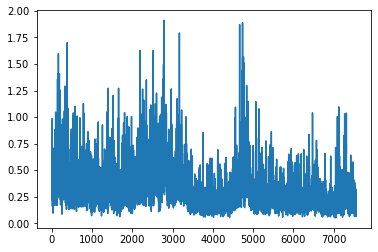

In [97]:
#draw daily vol
n = len(df_msft)
x = np.linspace(0, n, n)
y = df_msft['daily_vol']
plt.plot(x, y)
plt.show()

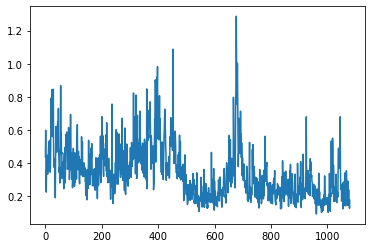

In [147]:
#draw weekly vol
n = len(df_msft_weekly)
x = np.linspace(0, n, n)
y = df_msft_weekly['weekly_vol']
plt.plot(x, y)
plt.show()

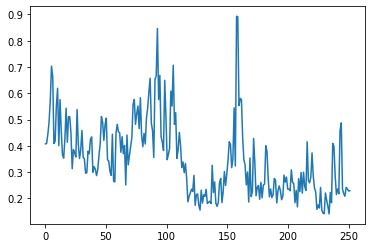

In [174]:
#draw weekly vol
n = len(df_msft_monthly)
x = np.linspace(0, n, n)
y = df_msft_monthly['monthly_vol']
plt.plot(x, y)
plt.show()

In [ ]:
#reindex
#df_msft = df_msft.reset_index()

In [98]:
#before droping na, save the data set
save_obj(df_msft,"pkl_data/df_msft_intra_day_30yr")

In [99]:
df_msft_w_na = load_obj("pkl_data/df_msft_intra_day_30yr")

In [28]:
#dropna
df_msft_final = df_msft.iloc[10:]

In [29]:
df_msft_final

,date,close_price,open_price,high_price,low_price,adj_volume,adjdilutedeps,dividend,daily_return,weekly_return,monthly_return,daily_vol_10d,weekly_vol_30d,monthly_vol_90d
10,1990-01-16,88.75,85.50,89.25,84.500,80092800.0,NaN,NaN,0.030082,-0.025036,NaN,0.020630,NaN,NaN
11,1990-01-17,87.50,88.00,90.50,87.000,97587216.0,NaN,NaN,-0.014185,-0.036470,NaN,0.020978,NaN,NaN
12,1990-01-18,95.00,89.62,95.00,89.500,292361616.0,NaN,NaN,0.082238,0.073703,NaN,0.033022,NaN,NaN
13,1990-01-19,94.12,95.25,96.00,93.500,99257616.0,NaN,NaN,-0.009306,0.084426,NaN,0.031899,NaN,NaN
14,1990-01-22,90.75,94.00,94.00,90.500,167686416.0,NaN,NaN,-0.036462,0.052367,NaN,0.034145,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553,2019-12-06,151.75,150.99,151.87,150.270,16410400.0,5.06,0.51,0.012066,-0.003749,0.075391,0.007272,0.016996,0.035440
7554,2019-12-09,151.36,151.07,152.21,150.910,16741350.0,5.06,0.51,-0.002573,-0.000132,0.048529,0.007385,0.017195,0.035499
7555,2019-12-10,151.13,151.29,151.89,150.765,16481060.0,5.06,0.51,-0.001521,0.010510,0.056485,0.006567,0.016151,0.035566
7556,2019-12-11,151.70,151.54,151.87,150.330,18860001.0,5.06,0.51,0.003764,0.015880,0.047864,0.006446,0.015868,0.034947


In [30]:
#save
save_obj(df_msft_final,"data/df_msft_final_30yr")

In [31]:
df_msft_final = load_obj("data/df_msft_final_30yr")

In [32]:
df_msft_final 

,date,close_price,open_price,high_price,low_price,adj_volume,adjdilutedeps,dividend,daily_return,weekly_return,monthly_return,daily_vol_10d,weekly_vol_30d,monthly_vol_90d
10,1990-01-16,88.75,85.50,89.25,84.500,80092800.0,NaN,NaN,0.030082,-0.025036,NaN,0.020630,NaN,NaN
11,1990-01-17,87.50,88.00,90.50,87.000,97587216.0,NaN,NaN,-0.014185,-0.036470,NaN,0.020978,NaN,NaN
12,1990-01-18,95.00,89.62,95.00,89.500,292361616.0,NaN,NaN,0.082238,0.073703,NaN,0.033022,NaN,NaN
13,1990-01-19,94.12,95.25,96.00,93.500,99257616.0,NaN,NaN,-0.009306,0.084426,NaN,0.031899,NaN,NaN
14,1990-01-22,90.75,94.00,94.00,90.500,167686416.0,NaN,NaN,-0.036462,0.052367,NaN,0.034145,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553,2019-12-06,151.75,150.99,151.87,150.270,16410400.0,5.06,0.51,0.012066,-0.003749,0.075391,0.007272,0.016996,0.035440
7554,2019-12-09,151.36,151.07,152.21,150.910,16741350.0,5.06,0.51,-0.002573,-0.000132,0.048529,0.007385,0.017195,0.035499
7555,2019-12-10,151.13,151.29,151.89,150.765,16481060.0,5.06,0.51,-0.001521,0.010510,0.056485,0.006567,0.016151,0.035566
7556,2019-12-11,151.70,151.54,151.87,150.330,18860001.0,5.06,0.51,0.003764,0.015880,0.047864,0.006446,0.015868,0.034947


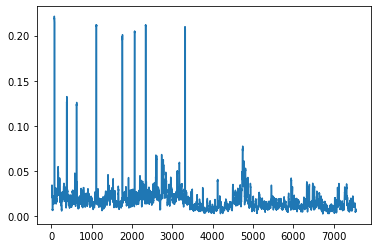

In [24]:
#draw daily vol
n = len(df_msft_final)
x = np.linspace(0, n, n)
y = df_msft_final['daily_vol_10d']
plt.plot(x, y)
plt.show()

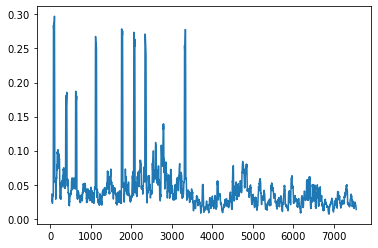

In [25]:
#draw weekly vol
n = len(df_msft_final)
x = np.linspace(0, n, n)
y = df_msft_final['weekly_vol_30d']
plt.plot(x, y)
plt.show()

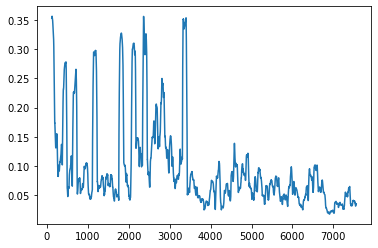

In [26]:
#draw monthly vol
n = len(df_msft_final)
x = np.linspace(0, n, n)
y = df_msft_final['monthly_vol_90d']
plt.plot(x, y)
plt.show()

In [12]:
import run
import importlib as ib

In [11]:
#daily vol (intraday)
df_msft_daily = load_obj("data/df_msft_daily")

In [35]:
ib.reload(run)

<module 'run' from 'C:\\Users\\Zijun\\Documents\\Projects\\Volatility Prediction\\run.py'>

In [36]:
#daily vol

[Model] Model Compiled
Time taken: 0:00:00.501239
[Model] Training Started
[Model] 10 epochs, 32 batch size, 201 batches per epoch
Epoch 1/10
201/201 [==============================] - 6s 30ms/step - loss: 0.4500
Epoch 2/10
201/201 [==============================] - 5s 24ms/step - loss: 0.4342
Epoch 3/10
201/201 [==============================] - 5s 24ms/step - loss: 0.4320
Epoch 4/10
201/201 [==============================] - 5s 23ms/step - loss: 0.4305
Epoch 5/10
201/201 [==============================] - 5s 26ms/step - loss: 0.4286
Epoch 6/10
201/201 [==============================] - 4s 22ms/step - loss: 0.4268
Epoch 7/10
201/201 [==============================] - 4s 21ms/step - loss: 0.4272
Epoch 8/10
201/201 [==============================] - 4s 21ms/step - loss: 0.4305
Epoch 9/10
201/201 [==============================] - 4s 22ms/step - loss: 0.4264
Epoch 10/10
201/201 [==============================] - 5s 26ms/step - loss: 0.4283: 0s - 
[Model] Training Completed. Model saved a

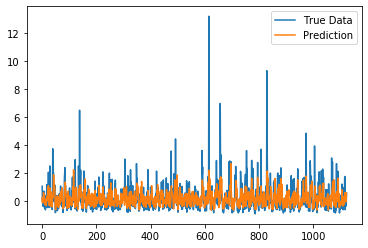

the mae of test sample is:  0.4759712841665677


In [37]:
run.main()

In [ ]:
#weekly vol

In [166]:
ib.reload(run)

<module 'run' from 'C:\\Users\\Zijun\\Documents\\Projects\\Volatility Prediction\\run.py'>

[Model] Model Compiled
Time taken: 0:00:01.457103
[Model] Training Started
[Model] 20 epochs, 32 batch size, 29 batches per epoch
Epoch 1/20
29/29 [==============================] - 2s 63ms/step - loss: 0.1532
Epoch 2/20
29/29 [==============================] - 1s 37ms/step - loss: 0.1306
Epoch 3/20
29/29 [==============================] - 1s 37ms/step - loss: 0.1254
Epoch 4/20
29/29 [==============================] - 1s 36ms/step - loss: 0.1480
Epoch 5/20
29/29 [==============================] - 1s 36ms/step - loss: 0.1229
Epoch 6/20
29/29 [==============================] - 1s 36ms/step - loss: 0.1202
Epoch 7/20
29/29 [==============================] - 1s 36ms/step - loss: 0.1202
Epoch 8/20
29/29 [==============================] - 1s 36ms/step - loss: 0.1157
Epoch 9/20
29/29 [==============================] - 1s 42ms/step - loss: 0.1139
Epoch 10/20
29/29 [==============================] - 1s 46ms/step - loss: 0.1085
Epoch 11/20
29/29 [==============================] - 1s 42ms/step - l

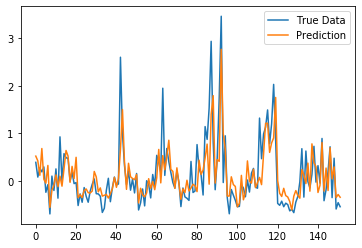

the mae of test sample is:  0.29766066182901985


In [167]:
run.main()

In [176]:
#monthly vol
ib.reload(run)

<module 'run' from 'C:\\Users\\Zijun\\Documents\\Projects\\Volatility Prediction\\run.py'>

[Model] Model Compiled
Time taken: 0:00:00.811894
[Model] Training Started
[Model] 20 epochs, 32 batch size, 7 batches per epoch
Epoch 1/20
7/7 [==============================] - 1s 146ms/step - loss: 0.1498
Epoch 2/20
7/7 [==============================] - 0s 28ms/step - loss: 0.1226
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 0.1157
Epoch 4/20
7/7 [==============================] - 0s 26ms/step - loss: 0.1096
Epoch 5/20
7/7 [==============================] - 0s 25ms/step - loss: 0.1093
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.1058
Epoch 7/20
7/7 [==============================] - 0s 25ms/step - loss: 0.1070
Epoch 8/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0642
Epoch 9/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0915
Epoch 10/20
7/7 [==============================] - 0s 26ms/step - loss: 0.1028
Epoch 11/20
7/7 [==============================] - 0s 28ms/step - loss: 0.1030
Epoch 12/2

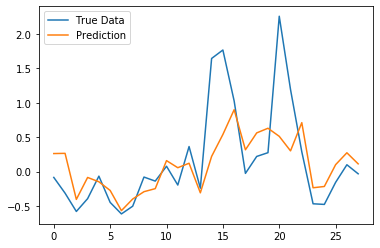

the mae of test sample is:  0.3827551233871


In [177]:
run.main()

In [81]:
#use all the features
ib.reload(run)

<module 'run' from 'C:\\Users\\Zijun\\Documents\\Projects\\Volatility Prediction\\run.py'>

[Model] Model Compiled
Time taken: 0:00:00.783311
[Model] Training Started
[Model] 20 epochs, 32 batch size, 40 batches per epoch
Epoch 1/20
40/40 [==============================] - 2s 40ms/step - loss: 0.2260
Epoch 2/20
40/40 [==============================] - 1s 21ms/step - loss: 0.1478
Epoch 3/20
40/40 [==============================] - 1s 20ms/step - loss: 0.1020
Epoch 4/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0794
Epoch 5/20
40/40 [==============================] - 1s 25ms/step - loss: 0.0726
Epoch 6/20
40/40 [==============================] - 1s 24ms/step - loss: 0.0643
Epoch 7/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0598
Epoch 8/20
40/40 [==============================] - 1s 22ms/step - loss: 0.0529
Epoch 9/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0485
Epoch 10/20
40/40 [==============================] - 1s 21ms/step - loss: 0.0460
Epoch 11/20
40/40 [==============================] - 1s 20ms/step - l

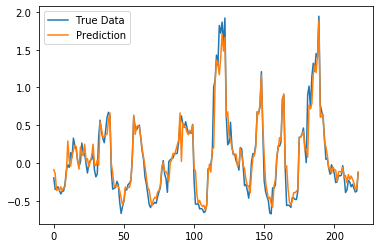

the mae of test sample is:  0.09496995558011048


In [82]:
run.main()

[Model] Model Compiled
Time taken: 0:00:02.293566
[Model] Training Started
[Model] 20 epochs, 32 batch size, 40 batches per epoch
Epoch 1/20
40/40 [==============================] - 3s 75ms/step - loss: 0.2377
Epoch 2/20
40/40 [==============================] - 2s 60ms/step - loss: 0.1667
Epoch 3/20
40/40 [==============================] - 2s 59ms/step - loss: 0.1102
Epoch 4/20
40/40 [==============================] - 2s 51ms/step - loss: 0.0869
Epoch 5/20
40/40 [==============================] - 2s 54ms/step - loss: 0.0737
Epoch 6/20
40/40 [==============================] - 2s 56ms/step - loss: 0.0619: 
Epoch 7/20
40/40 [==============================] - 2s 53ms/step - loss: 0.0574
Epoch 8/20
40/40 [==============================] - 2s 52ms/step - loss: 0.0520
Epoch 9/20
40/40 [==============================] - 2s 53ms/step - loss: 0.0457
Epoch 10/20
40/40 [==============================] - 2s 61ms/step - loss: 0.0427
Epoch 11/20
40/40 [==============================] - 2s 53ms/step -

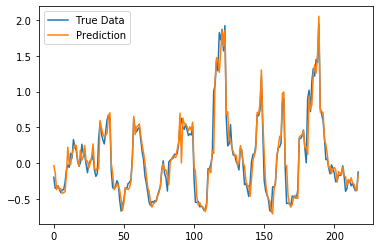

the mae of test sample is:  0.09449591557586588


In [87]:
#without volume
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.780700
[Model] Training Started
[Model] 20 epochs, 32 batch size, 40 batches per epoch
Epoch 1/20
40/40 [==============================] - 3s 78ms/step - loss: 0.1119
Epoch 2/20
40/40 [==============================] - 2s 57ms/step - loss: 0.0687
Epoch 3/20
40/40 [==============================] - 2s 57ms/step - loss: 0.0426
Epoch 4/20
40/40 [==============================] - 2s 58ms/step - loss: 0.0393
Epoch 5/20
40/40 [==============================] - 3s 66ms/step - loss: 0.0294
Epoch 6/20
40/40 [==============================] - 3s 64ms/step - loss: 0.0270
Epoch 7/20
40/40 [==============================] - 3s 63ms/step - loss: 0.0230
Epoch 8/20
40/40 [==============================] - 2s 60ms/step - loss: 0.0212
Epoch 9/20
40/40 [==============================] - 3s 71ms/step - loss: 0.0180
Epoch 10/20
40/40 [==============================] - 3s 73ms/step - loss: 0.0203
Epoch 11/20
40/40 [==============================] - 3s 76ms/step - l

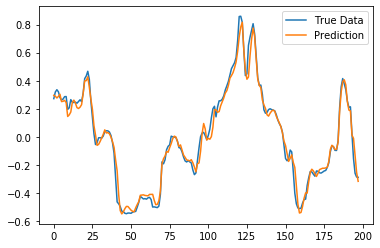

the mae of test sample is:  0.03500349104127174


In [83]:
#weekly vol
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:01.070889
[Model] Training Started
[Model] 20 epochs, 32 batch size, 40 batches per epoch
Epoch 1/20
40/40 [==============================] - 4s 101ms/step - loss: 0.1197
Epoch 2/20
40/40 [==============================] - 3s 73ms/step - loss: 0.0607
Epoch 3/20
40/40 [==============================] - 3s 76ms/step - loss: 0.0407
Epoch 4/20
40/40 [==============================] - 3s 76ms/step - loss: 0.0343
Epoch 5/20
40/40 [==============================] - 3s 74ms/step - loss: 0.0248
Epoch 6/20
40/40 [==============================] - 3s 79ms/step - loss: 0.0247
Epoch 7/20
40/40 [==============================] - 3s 80ms/step - loss: 0.0211
Epoch 8/20
40/40 [==============================] - 3s 81ms/step - loss: 0.0283
Epoch 9/20
40/40 [==============================] - 4s 88ms/step - loss: 0.0167
Epoch 10/20
40/40 [==============================] - 3s 84ms/step - loss: 0.0192
Epoch 11/20
40/40 [==============================] - 3s 78ms/step - 

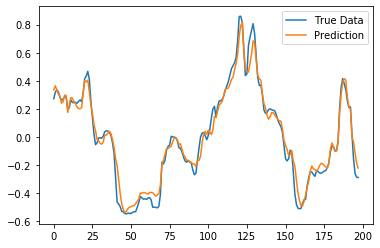

the mae of test sample is:  0.04462828007865752


In [84]:
#weekly vol + volume
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.523562
[Model] Training Started
[Model] 20 epochs, 32 batch size, 40 batches per epoch
Epoch 1/20
40/40 [==============================] - 3s 77ms/step - loss: 0.1202
Epoch 2/20
40/40 [==============================] - 2s 56ms/step - loss: 0.0580
Epoch 3/20
40/40 [==============================] - 2s 54ms/step - loss: 0.0440
Epoch 4/20
40/40 [==============================] - 2s 55ms/step - loss: 0.0327: 0s - loss:
Epoch 5/20
40/40 [==============================] - 2s 57ms/step - loss: 0.0304
Epoch 6/20
40/40 [==============================] - 2s 59ms/step - loss: 0.0230
Epoch 7/20
40/40 [==============================] - 2s 55ms/step - loss: 0.0254
Epoch 8/20
40/40 [==============================] - 2s 55ms/step - loss: 0.0204
Epoch 9/20
40/40 [==============================] - 2s 55ms/step - loss: 0.0185
Epoch 10/20
40/40 [==============================] - 2s 55ms/step - loss: 0.0199
Epoch 11/20
40/40 [==============================] - 2s 5

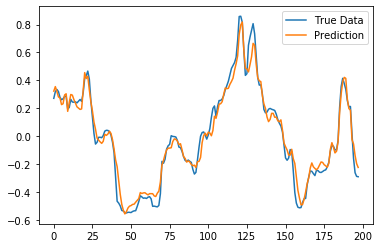

the mae of test sample is:  0.04592185660206939


In [9]:
#weekly vol + volume + price to book
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.364026
[Model] Training Started
[Model] 20 epochs, 32 batch size, 40 batches per epoch
Epoch 1/20
40/40 [==============================] - 3s 79ms/step - loss: 0.1260
Epoch 2/20
40/40 [==============================] - 2s 62ms/step - loss: 0.0697
Epoch 3/20
40/40 [==============================] - 2s 59ms/step - loss: 0.0387
Epoch 4/20
40/40 [==============================] - 2s 59ms/step - loss: 0.0336
Epoch 5/20
40/40 [==============================] - 2s 60ms/step - loss: 0.0318
Epoch 6/20
40/40 [==============================] - 2s 60ms/step - loss: 0.0256
Epoch 7/20
40/40 [==============================] - 2s 59ms/step - loss: 0.0284
Epoch 8/20
40/40 [==============================] - 2s 62ms/step - loss: 0.0210
Epoch 9/20
40/40 [==============================] - 2s 61ms/step - loss: 0.0191
Epoch 10/20
40/40 [==============================] - 2s 60ms/step - loss: 0.0212
Epoch 11/20
40/40 [==============================] - 2s 62ms/step - l

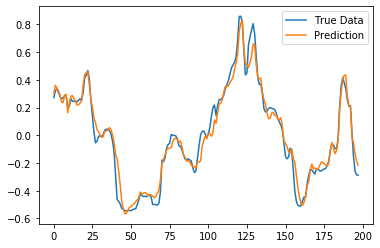

the mae of test sample is:  0.04624166373302408


In [10]:
#all features
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.460300
[Model] Training Started
[Model] 20 epochs, 32 batch size, 38 batches per epoch
Epoch 1/20
38/38 [==============================] - 7s 195ms/step - loss: 0.0492
Epoch 2/20
38/38 [==============================] - 7s 177ms/step - loss: 0.0158
Epoch 3/20
38/38 [==============================] - 7s 176ms/step - loss: 0.0143
Epoch 4/20
38/38 [==============================] - 7s 175ms/step - loss: 0.0108
Epoch 5/20
38/38 [==============================] - 7s 185ms/step - loss: 0.0125
Epoch 6/20
38/38 [==============================] - 7s 192ms/step - loss: 0.0091
Epoch 7/20
38/38 [==============================] - 8s 202ms/step - loss: 0.0137
Epoch 8/20
38/38 [==============================] - 8s 198ms/step - loss: 0.0074
Epoch 9/20
38/38 [==============================] - 8s 211ms/step - loss: 0.0101
Epoch 10/20
38/38 [==============================] - 8s 211ms/step - loss: 0.0086
Epoch 11/20
38/38 [==============================] - 8s 221

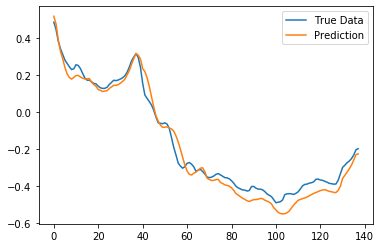

the mae of test sample is:  0.041658293326289134


In [11]:
#monthly vol
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.492190
[Model] Training Started
[Model] 20 epochs, 32 batch size, 38 batches per epoch
Epoch 1/20
38/38 [==============================] - 7s 176ms/step - loss: 0.0592
Epoch 2/20
38/38 [==============================] - 6s 163ms/step - loss: 0.0198
Epoch 3/20
38/38 [==============================] - 6s 159ms/step - loss: 0.0291
Epoch 4/20
38/38 [==============================] - 6s 159ms/step - loss: 0.0118
Epoch 5/20
38/38 [==============================] - 6s 164ms/step - loss: 0.0110
Epoch 6/20
38/38 [==============================] - 6s 159ms/step - loss: 0.0095
Epoch 7/20
38/38 [==============================] - 6s 171ms/step - loss: 0.0074
Epoch 8/20
38/38 [==============================] - 7s 177ms/step - loss: 0.0120
Epoch 9/20
38/38 [==============================] - 7s 179ms/step - loss: 0.0093
Epoch 10/20
38/38 [==============================] - 7s 183ms/step - loss: 0.0129
Epoch 11/20
38/38 [==============================] - 7s 177

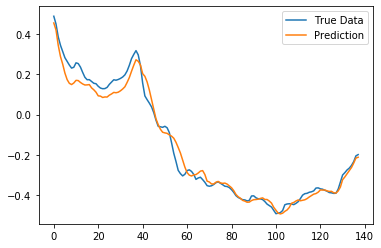

the mae of test sample is:  0.030537950310216534


In [12]:
#monthly vol + adj_volume
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.426832
[Model] Training Started
[Model] 20 epochs, 32 batch size, 38 batches per epoch
Epoch 1/20
38/38 [==============================] - 8s 217ms/step - loss: 0.0612
Epoch 2/20
38/38 [==============================] - 10s 252ms/step - loss: 0.0215
Epoch 3/20
38/38 [==============================] - 9s 245ms/step - loss: 0.0369
Epoch 4/20
38/38 [==============================] - 9s 234ms/step - loss: 0.0105
Epoch 5/20
38/38 [==============================] - 9s 234ms/step - loss: 0.0099
Epoch 6/20
38/38 [==============================] - 9s 244ms/step - loss: 0.0081
Epoch 7/20
38/38 [==============================] - 9s 249ms/step - loss: 0.0073
Epoch 8/20
38/38 [==============================] - 11s 288ms/step - loss: 0.0068
Epoch 9/20
38/38 [==============================] - 11s 293ms/step - loss: 0.0131
Epoch 10/20
38/38 [==============================] - 11s 289ms/step - loss: 0.0181
Epoch 11/20
38/38 [==============================] - 11

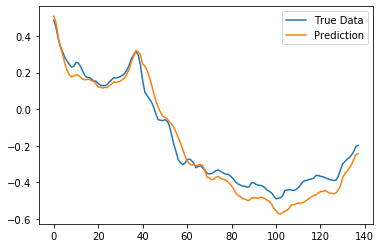

the mae of test sample is:  0.05404464528478394


In [13]:
#vol+volume+pricetobook
ib.reload(run)
run.main()

[Model] Model Compiled
Time taken: 0:00:00.439299
[Model] Training Started
[Model] 20 epochs, 32 batch size, 38 batches per epoch
Epoch 1/20
38/38 [==============================] - 9s 236ms/step - loss: 0.0851
Epoch 2/20
38/38 [==============================] - 10s 254ms/step - loss: 0.0313
Epoch 3/20
38/38 [==============================] - 10s 257ms/step - loss: 0.0199
Epoch 4/20
38/38 [==============================] - 10s 258ms/step - loss: 0.0268
Epoch 5/20
38/38 [==============================] - 10s 271ms/step - loss: 0.0109
Epoch 6/20
38/38 [==============================] - 10s 271ms/step - loss: 0.0185
Epoch 7/20
38/38 [==============================] - 11s 283ms/step - loss: 0.0133
Epoch 8/20
38/38 [==============================] - 12s 320ms/step - loss: 0.0122
Epoch 9/20
38/38 [==============================] - 12s 319ms/step - loss: 0.0096
Epoch 10/20
38/38 [==============================] - 12s 318ms/step - loss: 0.0170
Epoch 11/20
38/38 [==============================]

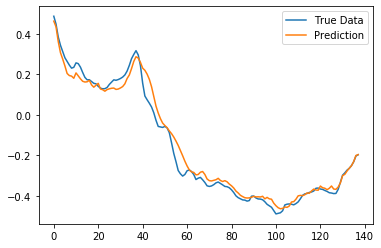

the mae of test sample is:  0.028939537869629394


In [14]:
#all features
ib.reload(run)
run.main()

In [5]:
#baseline garch
import warnings
warnings.simplefilter('ignore')d

%matplotlib inline
import seaborn
seaborn.set_style('darkgrid')

from arch import arch_model

seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90
seaborn.mpl.rcParams['font.family'] = 'sans-serif'
seaborn.mpl.rcParams['font.size'] = 14


In [13]:
import datetime as dt

In [37]:
df_msft_w_na["daily_vol_10d"][9]

nan

In [34]:
df_msft_w_na

,level_0,index,date,adj_close_price,adj_volume,pricetobook,netdebttoebitda,ltdebttoebitda,adjdilutedeps,dividend,daily_return,weekly_return,monthly_return,daily_vol_10d,weekly_vol_30d,monthly_vol_90d
0,63,1634,2013-04-01,24.467667,29203122.0,2.6893,-2.8782,0.4811,1.95,0.23,NaN,NaN,NaN,NaN,NaN,NaN
1,64,1633,2013-04-02,24.630158,28460384.0,2.7072,-2.8782,0.4811,1.95,0.23,0.006619,NaN,NaN,NaN,NaN,NaN
2,65,1632,2013-04-03,24.424907,35064468.0,2.6846,-2.8782,0.4811,1.95,0.23,-0.008368,NaN,NaN,NaN,NaN,NaN
3,66,1631,2013-04-04,24.454839,45267601.0,2.6879,-2.8782,0.4811,1.95,0.23,0.001225,NaN,NaN,NaN,NaN,NaN
4,67,1630,2013-04-05,24.544637,50928776.0,2.6978,-2.8782,0.4811,1.95,0.23,0.003665,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,1693,4,2019-09-17,136.924085,17976285.0,10.3740,-1.1611,1.2039,5.06,0.46,0.007745,-0.000946,0.023172,0.010198,0.019840,0.039727
1631,1694,3,2019-09-18,138.050253,24473386.0,10.4593,-1.1611,1.2039,5.06,0.46,0.008191,0.017772,0.026992,0.009853,0.018114,0.039507
1632,1695,2,2019-09-19,140.591606,36095413.0,10.6519,-1.1611,1.2039,5.06,0.46,0.018242,0.035719,0.018898,0.010008,0.017611,0.039541
1633,1696,1,2019-09-20,138.967133,40040766.0,10.5288,-1.1611,1.2039,5.06,0.46,-0.011622,0.013865,0.015809,0.010514,0.017486,0.039571


In [12]:
df_msft_final

,level_0,index,date,adj_close_price,adj_volume,pricetobook,netdebttoebitda,ltdebttoebitda,adjdilutedeps,dividend,daily_return,weekly_return,monthly_return,daily_vol_10d,weekly_vol_30d,monthly_vol_90d
118,181,1516,2013-09-16,28.447629,55017879.0,3.0522,-2.3458,0.4090,2.58,0.23,-0.006957,0.051581,0.041164,0.020204,0.047429,0.089872
119,182,1515,2013-09-17,28.559508,84716461.0,3.0642,-2.3458,0.4090,2.58,0.23,0.003925,0.039488,0.048882,0.012683,0.047802,0.089141
120,183,1514,2013-09-18,28.897747,64103344.0,3.1005,-2.3458,0.4090,2.58,0.23,0.011774,0.028308,0.045477,0.009341,0.047932,0.088328
121,184,1513,2013-09-19,29.175276,42026553.0,3.1303,-2.3458,0.4090,2.58,0.23,0.009558,0.027118,0.029569,0.009183,0.048048,0.086938
122,185,1512,2013-09-20,28.438956,102904859.0,3.0513,-2.3458,0.4090,2.58,0.23,-0.025562,0.003085,0.009801,0.013714,0.047859,0.085327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,1693,4,2019-09-17,136.924085,17976285.0,10.3740,-1.1611,1.2039,5.06,0.46,0.007745,-0.000946,0.023172,0.010198,0.019840,0.039727
1631,1694,3,2019-09-18,138.050253,24473386.0,10.4593,-1.1611,1.2039,5.06,0.46,0.008191,0.017772,0.026992,0.009853,0.018114,0.039507
1632,1695,2,2019-09-19,140.591606,36095413.0,10.6519,-1.1611,1.2039,5.06,0.46,0.018242,0.035719,0.018898,0.010008,0.017611,0.039541
1633,1696,1,2019-09-20,138.967133,40040766.0,10.5288,-1.1611,1.2039,5.06,0.46,-0.011622,0.013865,0.015809,0.010514,0.017486,0.039571


In [104]:
#take the prev day volatility
vol_10d = df_msft["daily_vol"]
vol_10d

0       0.398692
1       0.222532
2       0.540781
3       0.402851
4       0.374835
          ...   
7553    0.134285
7554    0.099192
7555    0.084480
7556    0.115155
7557    0.220607
Name: daily_vol, Length: 7558, dtype: float64

In [135]:
#split train and test by 85/15 as what's been done in the neural networks
index_mask = math.floor(0.85 * len(vol_10d))

y_real = vol_10d[index_mask:-1]
#take prev day
y_pred_naive = vol_10d[index_mask-1:-2]

In [136]:
len(y_real)

1133

In [137]:
len(y_pred_naive)

1133

In [138]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae_naive = mean_absolute_error(y_real,y_pred_naive)

In [139]:
mae_naive

0.11738772577305935

In [148]:
#take the prev day volatility
vol_weekly = df_msft_weekly["weekly_vol"]
#split train and test by 85/15 as what's been done in the neural networks
index_mask = math.floor(0.85 * len(vol_weekly))

y_real_w = vol_weekly[index_mask:-1]
#take prev day
y_pred_naive_w = vol_weekly[index_mask-1:-2]

mae_naive_weekly = mean_absolute_error(y_real_w,y_pred_naive_w)
mae_naive_weekly


0.0733940329936427

In [175]:
#take the prev day volatility
vol_monthly = df_msft_monthly["monthly_vol"]
#split train and test by 85/15 as what's been done in the neural networks
index_mask = math.floor(0.85 * len(vol_monthly))

y_real_m = vol_monthly[index_mask:-1]
#take prev day
y_pred_naive_m = vol_monthly[index_mask-1:-2]

mae_naive_monthly = mean_absolute_error(y_real_m,y_pred_naive_m)
mae_naive_monthly


0.06171802401793001